# clEsperanto
[clEsperanto](http://clesperanto.net) 是一个跨多个生物图像分析生态系统的项目，旨在消除语言障碍。它基于 [OpenCL](https://www.khronos.org/opencl/)，这是一个用于编程图形处理单元（GPU 等）的开放标准，以及其 Python 封装 [pyopencl](https://documen.tician.de/pyopencl/)。在底层，它使用来自 [clij](https://clij.github.io) 项目的处理内核。

另请参阅
* [Fiji 和 Napari 中的 GPU 加速图像分析，EuroBioimaging 虚拟酒吧](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU 初始化
我们首先初始化并查看安装了哪些 GPU：

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import stackview

# list available devices
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [2]:
# select a specific device with only a part of its name
cle.select_device("2080")

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with 2080 in their name. Using gfx1035 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

## 处理图像
对于加载图像数据，我们像往常一样使用 scikit-image：

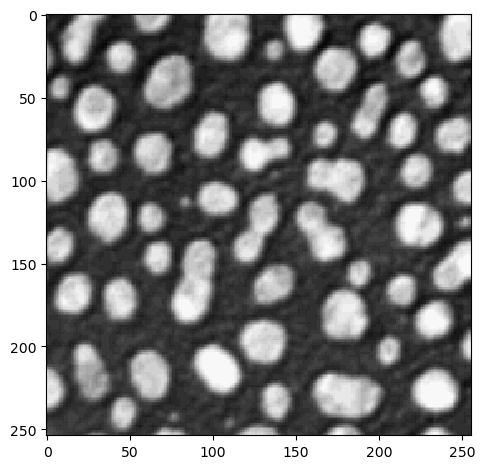

In [4]:
from skimage.io import imread, imshow

image = imread("../../data/blobs.tif")
imshow(image)

`cle.` 网关包含了你需要的所有方法，它没有子包：

cl.OCLArray([[ 41.428753,  34.696438,  27.733936, ..., 220.92714 , 211.21164 ,
        206.71573 ],
       [ 47.421425,  38.878723,  30.323011, ..., 228.32323 , 220.60194 ,
        216.83534 ],
       [ 48.121437,  40.610855,  33.357384, ..., 235.32935 , 229.7049  ,
        226.88821 ],
       ...,
       [ 74.4386  ,  76.32904 ,  77.03725 , ...,  48.000324,  48.00075 ,
         48.001007],
       [ 81.793655,  81.17787 ,  79.80763 , ...,  48.      ,  48.      ,
         48.      ],
       [ 88.816925,  85.382095,  81.478806, ...,  48.      ,  48.      ,
         48.      ]], dtype=float32)
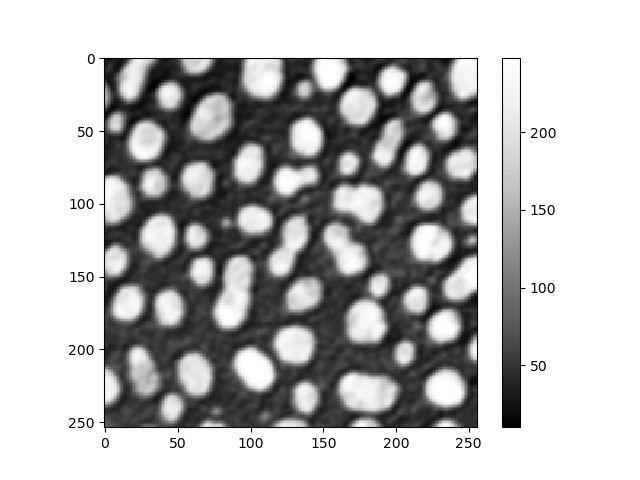
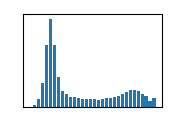

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
blurred

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
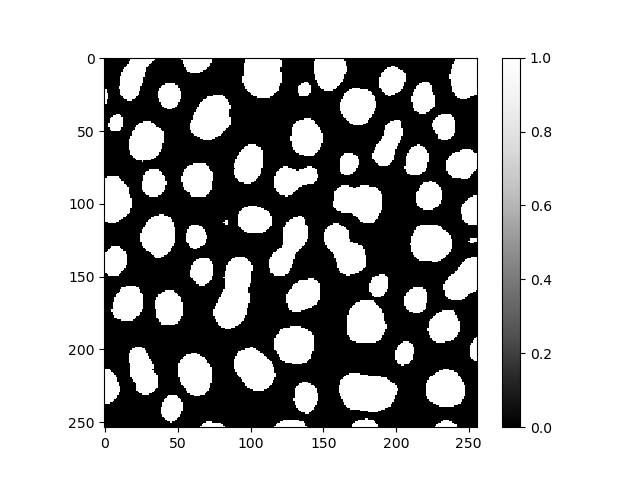
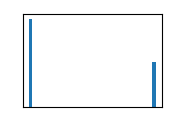

In [6]:
# binarization
binary = cle.threshold_otsu(blurred)
binary

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
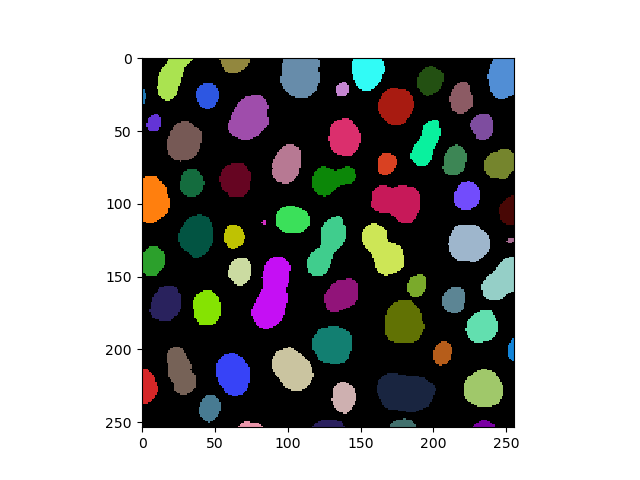

In [7]:
# labeling
labels = cle.connected_components_labeling_box(binary)
labels

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


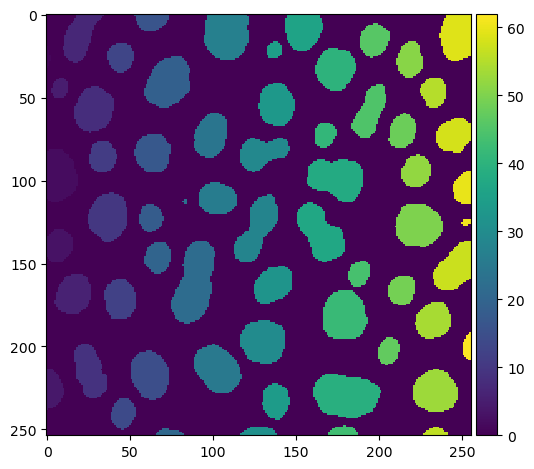

In [8]:
# visualize results
imshow(labels)

`stackview` 还带有一个 imshow 函数，它允许更方便地显示标签图像：

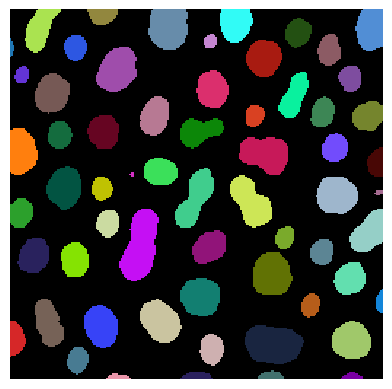

In [9]:
stackview.imshow(labels)

还可以确定标签边缘并将它们混合到图像上。

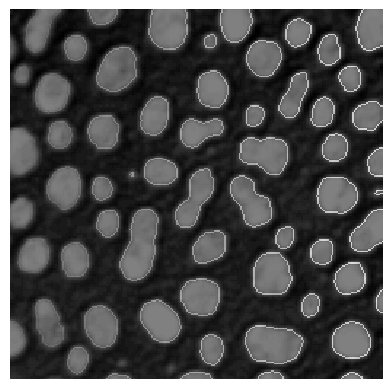

In [10]:
label_edges = cle.detect_label_edges(labels) * labels

stackview.imshow(image, continue_drawing=True)
stackview.imshow(label_edges, alpha=0.5)

因此，增加图形大小并组合多个子图可能是有意义的

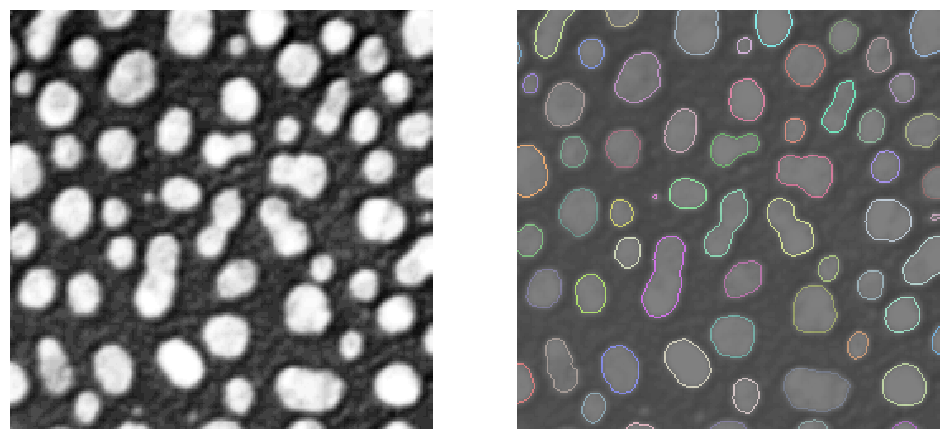

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# left plot
stackview.imshow(image, plot=axs[0])

# right plot
stackview.imshow(image, alpha=0.5, continue_drawing=True, plot=axs[1])
stackview.imshow(label_edges, labels=True, alpha=0.5, plot=axs[1])

其中一些操作，例如 [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb)，实际上是快捷方式，它们结合了多个操作，如高斯模糊、Voronoi 标记和 Otsu 阈值处理，直接从原始图像得到标签图像：

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
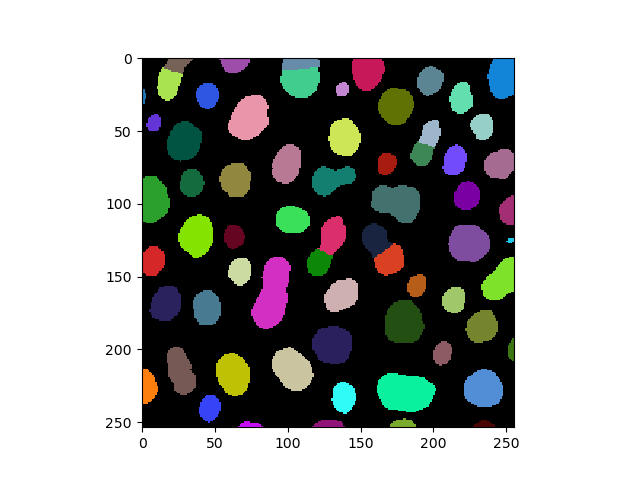

In [12]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)
labels

另外，再次提醒，请阅读你之前未使用过的方法的文档：

In [13]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.

    Notes
    -----
    * This operation assumes input images are isotropic.

    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float, optional
        controls how close detected cells can be
    outline_sigma : float, optional
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    --

## 互操作性
在 pyclesperanto 中，图像在 GPU 的随机存取存储器（RAM）中处理。如果你想使用其他在 GPU 上处理图像的库，内存必须被传回。通常，这对用户来说是透明的，例如在使用 scikit-image 测量区域属性时：

In [14]:
from skimage.measure import regionprops

statistics = regionprops(labels)

import numpy as np
np.mean([s.area for s in statistics])

333.77272727272725

如果你想显式地转换你的图像，例如转换为 numpy 数组，你可以这样做：

In [15]:
np.asarray(labels)

array([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## 内存管理
在 Jupyter 笔记本中，只要笔记本内核在运行，变量就会保持活跃状态。因此，你的 GPU 可能会被内存填满。因此，如果你不再需要一个图像，请使用 `del` 从内存中删除它。由于 [pyopencl](https://documen.tician.de/pyopencl/) 的魔法，它将从 GPU 内存中被移除。

In [16]:
del image
del blurred
del binary
del labels